#### Model Training

##### 1.1 Import Data and Required Packages

Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [125]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import warnings

Import the CSV Data as Pandas DataFrame


In [126]:
df = pd.read_csv('diabetes-2-1.csv')

Show Top 5 Records

In [127]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Replace the Zeros Values

In [128]:
# Create an instance of SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Define the columns you want to impute
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zero values with NaN
df.loc[:, columns_to_impute] = df[columns_to_impute].replace(0, np.nan)


# Fit the imputer on the columns with missing values
imputer.fit(df[columns_to_impute])

# Transform the DataFrame by imputing missing values
df[columns_to_impute] = imputer.transform(df[columns_to_impute])

In [129]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Preparing X and Y variables

In [130]:
# independent and dependent features
X = df.drop('Outcome',axis=1) #df.iloc[:,:-1]
y = df['Outcome'] # df.iloc[:,-1]

Train Test split

In [131]:
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [132]:
print(X.shape,X_test.shape,X_train.shape)

(768, 8) (154, 8) (614, 8)


In [133]:

# features_to_scale_robust = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age']


# def count_outliers(feature, df):
#     # Calculate the quartiles and interquartile range (IQR)
#     Q1 = feature.quantile(0.25)
#     Q3 = feature.quantile(0.75)
#     IQR = Q3 - Q1
#     # Calculate the lower and upper bounds for outliers detection
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     # Filter the dataframe to remove outliers based on the calculated bounds
#     df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
#     # Count the number of outliers
#     num_outliers = ((feature < lower_bound) | (feature > upper_bound)).sum()
#     return num_outliers, df_without_outlier

# df_cleaned = df.copy()  # Create a copy of the original dataframe

# total_outliers_deleted = 0  # Initialize variable to store the total number of deleted outliers

# for feature in features_to_scale_robust:
#     # Call count_outliers function to count outliers and get cleaned dataframe
#     num_outliers, df_cleaned = count_outliers(df[feature], df_cleaned)
#     print(f'Number of outliers in {feature}: {num_outliers}')
#     total_outliers_deleted += num_outliers  # Add the number of outliers deleted for each feature

Data Standarization

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Training the Model

1. Logistic Regression

In [135]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

2. Support Vector Machine SVM

In [136]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)

SVC()

3. K Nearest Neighbors


In [137]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

4. Naive Bayes 

In [138]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

5. Decision Tree

In [139]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

6. Random Forest

In [140]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

#### Best Parmeters for Models

In [141]:
from sklearn.model_selection import GridSearchCV

# Define Models
models = [lr, knn, nb, svm, dt, rf]

# Define the hyperparameter grid for Logistic Regression model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

# Define the hyperparameter grid for KNN model
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

# Define the hyperparameter grid for Naive Bayes model (Note: Naive Bayes doesn't have hyperparameters to tune)
param_grid_nb = {
    # Naive Bayes does not have hyperparameters to tune
}

# Define the hyperparameter grid for SVM model
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Define the hyperparameter grid for Decision Tree model
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Adjusted 'max_features' parameter values
}

# Define the hyperparameter grid for Random Forest model
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Define a list of param_grids corresponding to each model
param_grids = [param_grid_lr, param_grid_knn, param_grid_nb, param_grid_svm, param_grid_dt, param_grid_rf]

# Iterate over each model and its corresponding param_grid
for i in range(len(models)):
    model = models[i]
    param_grid = param_grids[i]
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Retrieve best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Update model with best parameters and fit the model
    model.set_params(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    # Print best parameters and best score
    print(f"Best Parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best Score for {model.__class__.__name__}: {best_score}\n")

{'model_name': 'LogisticRegression', 'accuracy': 0.8051948051948052, 'precision': 0.7297297297297297, 'recall': 0.574468085106383, 'f1': 0.6428571428571429, 'roc_auc': 0.7405050705905747}
Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Best Score for LogisticRegression: 0.7622284419565506



{'model_name': 'KNeighborsClassifier', 'accuracy': 0.7922077922077922, 'precision': 0.6595744680851063, 'recall': 0.6595744680851063, 'f1': 0.6595744680851063, 'roc_auc': 0.7550208789023662}
Best Parameters for KNeighborsClassifier: {'n_neighbors': 9, 'weights': 'distance'}
Best Score for KNeighborsClassifier: 0.7573770491803279

{'model_name': 'GaussianNB', 'accuracy': 0.7857142857142857, 'precision': 0.6590909090909091, 'recall': 0.6170212765957447, 'f1': 0.6373626373626374, 'roc_auc': 0.7384171803539471}
Best Parameters for GaussianNB: {}
Best Score for GaussianNB: 0.7426895908303346

{'model_name': 'SVC', 'accuracy': 0.7987012987012987, 'precision': 0.7222222222222222, 'recall': 0.5531914893617021, 'f1': 0.6265060240963856, 'roc_auc': 0.7298667727182342}
Best Parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score for SVC: 0.7589764094362256

{'model_name': 'DecisionTreeClassifier', 'accuracy': 0.7857142857142857, 'precision': 0.64, 'recall': 0.680851063829787

### Assess the complexity of each model

In [142]:
def assess_model_complexity(model):
    num_parameters = model._get_param_names()  # Get the names of the parameters
    computational_complexity = "High" if hasattr(model, "decision_function") else "Low"  # Check if the model has a decision function
    interpretability = "High" if hasattr(model, "feature_importances_") else "Low"  # Check if the model has feature importances
    return num_parameters, computational_complexity, interpretability

In [143]:
# Initialize an empty list to store the rows of the table
table_data = []

# Populate the table data with the complexity assessment for each model
for model, model_name in zip(models, ["Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "Support Vector Machine", "Decision Tree", "Random Forest"]):
    num_parameters, computational_complexity, interpretability = assess_model_complexity(model)
    table_data.append([model_name, len(num_parameters), computational_complexity, interpretability])

# Define the headers for the table
headers = ["Model", "Num Parameters", "Computational Complexity", "Interpretability"]

# Convert the table data to a DataFrame
df = pd.DataFrame(table_data, columns=headers)

# Print the DataFrame
display(df)


,Model,Num Parameters,Computational Complexity,Interpretability
0,Logistic Regression,15,High,Low
1,K-Nearest Neighbors,8,Low,Low
2,Naive Bayes,2,Low,Low
3,Support Vector Machine,15,High,Low
4,Decision Tree,12,Low,High
5,Random Forest,18,Low,High


### Model Visulazation

In [144]:
# Import necessary functions/classes from sklearn
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X_train, y_train, cv=None, n_jobs=-1, ax=None):
    # Generate learning curves using learning_curve function
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=n_jobs)
    # Compute mean and standard deviation of training scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    # Compute mean and standard deviation of test scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Fill the area between the training score curves
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    # Fill the area between the test score curves
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    # Plot the training score curve
    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    # Plot the cross-validation score curve
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    # Set title of the plot
    ax.set_title(title)
    # Set label for x-axis
    ax.set_xlabel("Training examples")
    # Set label for y-axis
    ax.set_ylabel("Score")
    # Add legend to the plot
    ax.legend(loc="best")

# Define a function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, ax=None):
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # Plot the diagonal dashed line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Set limits for x-axis
    ax.set_xlim([0.0, 1.0])
    # Set limits for y-axis
    ax.set_ylim([0.0, 1.05])
    # Set label for x-axis
    ax.set_xlabel('False Positive Rate')
    # Set label for y-axis
    ax.set_ylabel('True Positive Rate')
    # Set title of the plot
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    # Add legend to the plot
    ax.legend(loc="lower right")

# Define a function to plot feature importance
def plot_feature_importance(model, feature_names, ax=None):
    # Get feature importances and sort them
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot feature importance
    ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance')

Learing Curve

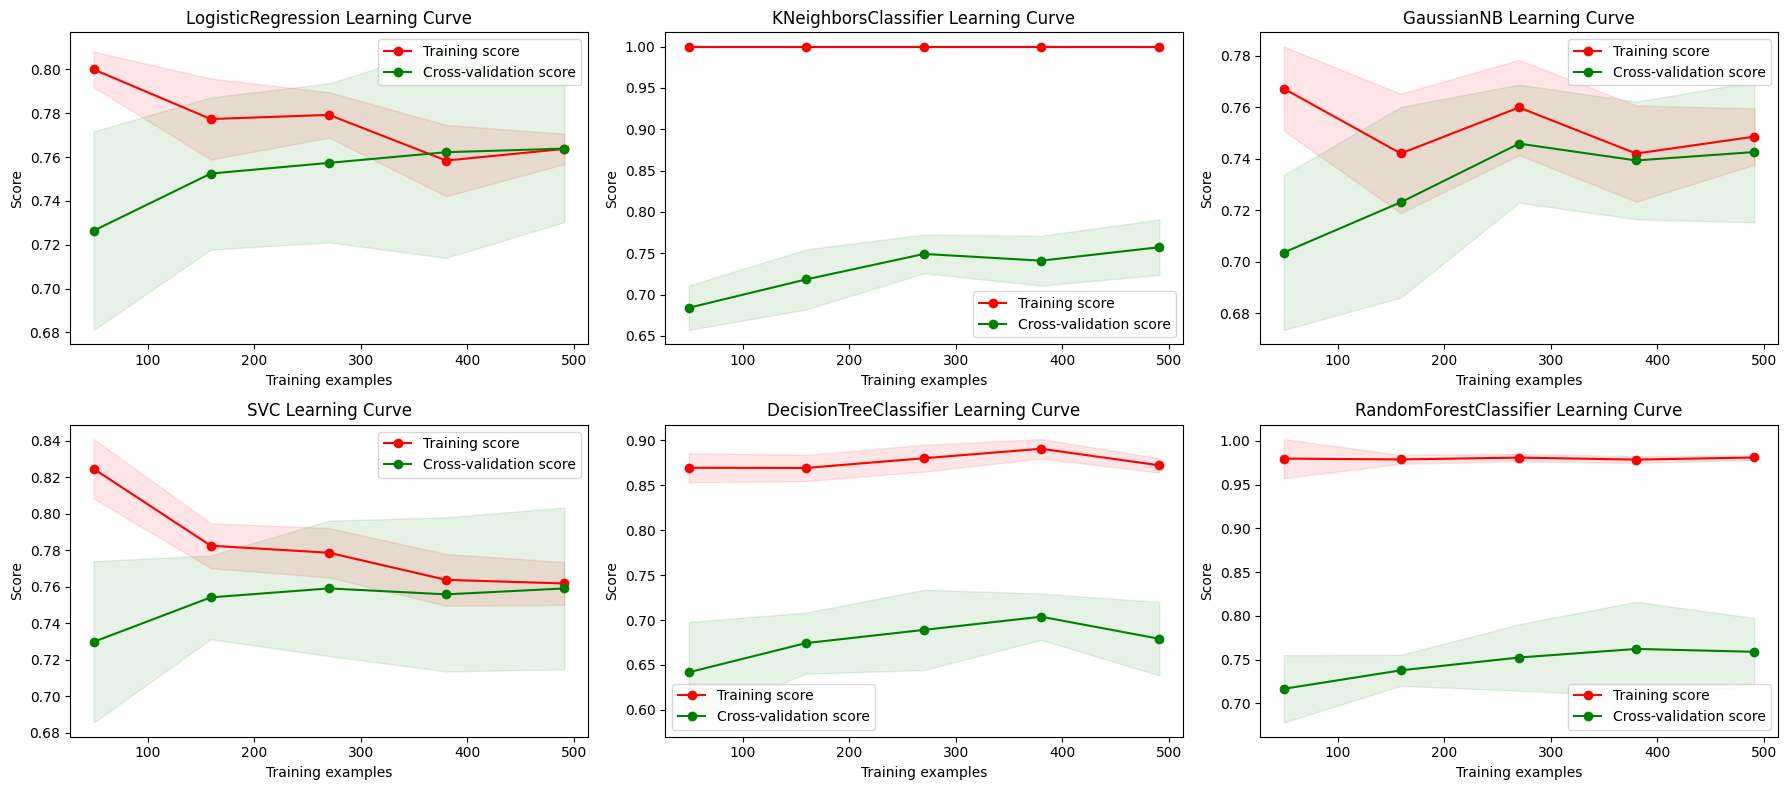

In [145]:
# Create subplots
models = [lr, knn, nb, svm, dt, rf]
# Define the layout of the grid
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(models):
    plot_learning_curve(model, f"{model.__class__.__name__} Learning Curve", X_train, y_train, cv=5, ax=axes[i])

    # Set title for each subplot
    axes[i].set_title(f"{model.__class__.__name__} Learning Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

ROC Curve

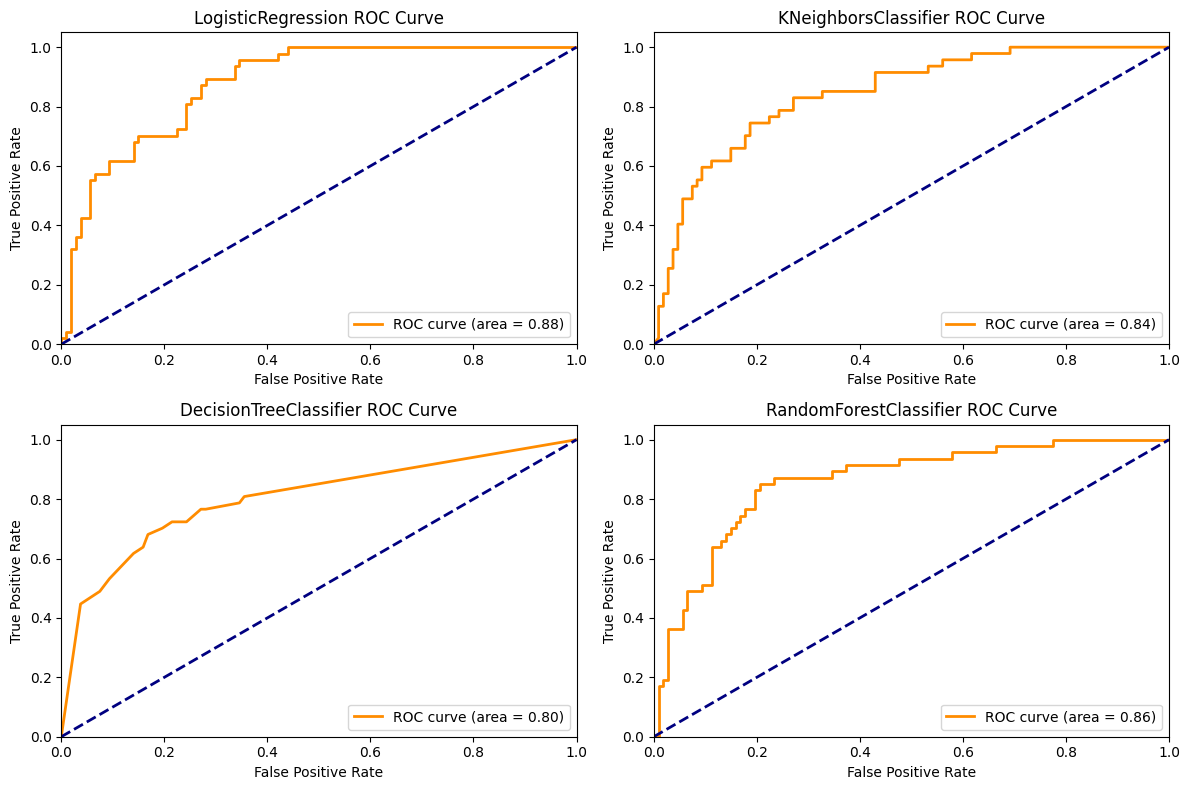

In [146]:
roc_models = [lr, knn, dt, rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(roc_models):
       plot_roc_curve(model, X_test, y_test, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} ROC Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

AUC Curve: This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

0.90 - 1.00 = excellent

0.80 - 0.90 = good

0.70 - 0.80 = fair

0.60 - 0.70 = poor

0.50 - 0.60 = fail

Feature Importance

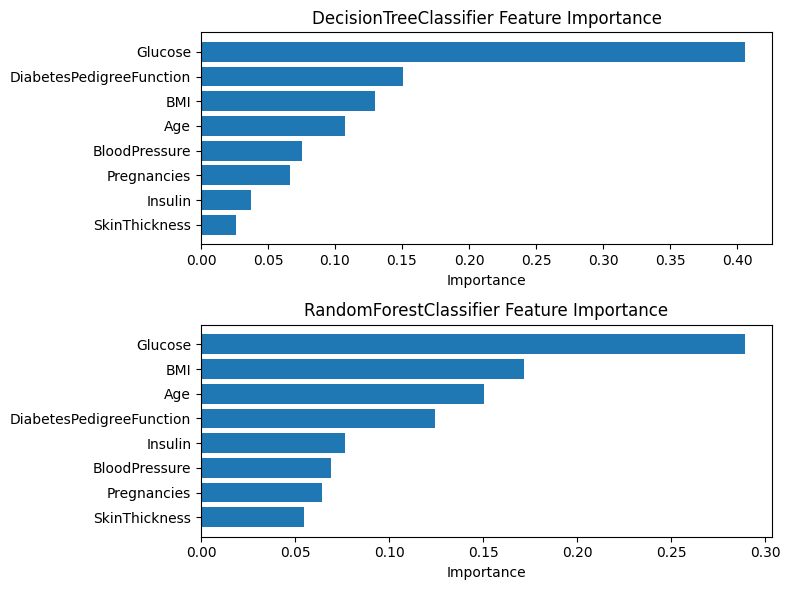

In [147]:
# Plot visualizations for each model
feature_importance_models = [dt, rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(feature_importance_models):
       plot_feature_importance(model, X.columns, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} Feature Importance")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Create an Evaluate Function to give all metrics after model Training

confusion Metrix

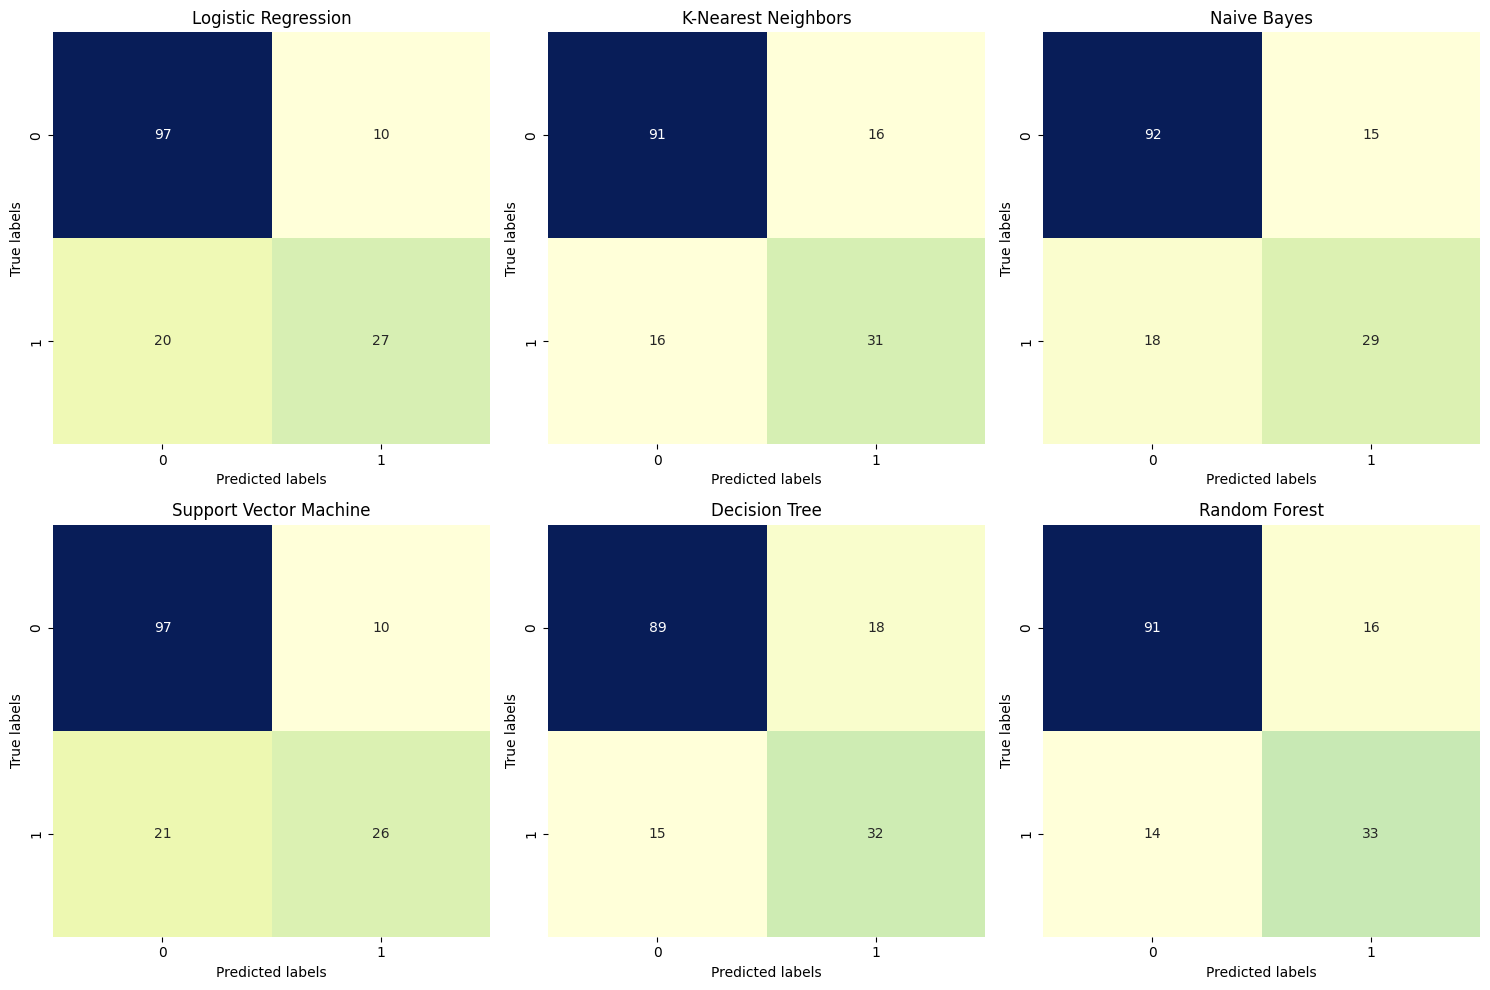

In [148]:
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrix and return TP, FP, TN, FN
def plot_confusion_matrix(ax, model, X_test, y_test, title):
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    
    # Extract TP, FP, TN, FN from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    return tp, fp, tn, fn

# Plot confusion matrices for each model in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
models_names = ["Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "Support Vector Machine", "Decision Tree", "Random Forest"]
results = []
for i, model in enumerate(models):
    row = i // 3
    col = i % 3
    tp, fp, tn, fn = plot_confusion_matrix(axes[row, col], model, X_test, y_test, models_names[i])
    results.append({"Model": models_names[i], "TP": tp, "FP": fp, "TN": tn, "FN": fn})

plt.tight_layout()
plt.show()


In [149]:
# Create DataFrame from results

results_df = pd.DataFrame(results)

# Reorder columns if needed
results_df = results_df[["Model", "TP", "FP", "TN", "FN"]]

# display DataFrame
display(results_df)

,Model,TP,FP,TN,FN
0,Logistic Regression,27,10,97,20
1,K-Nearest Neighbors,31,16,91,16
2,Naive Bayes,29,15,92,18
3,Support Vector Machine,26,10,97,21
4,Decision Tree,32,18,89,15
5,Random Forest,33,16,91,14


In each cell, "TP" represents True Positives, "FP" represents False Positives, and "FN" represents False Negatives. "TN" represents True Negatives. These values are filled in for both the diabetic and non-diabetic classes for each model. Additionally, the overall accuracy (ACC) and F1-score (F1) are included for each model.

#### accuracy score, precision score, recall score, f1 score, roc_auc_score

In [150]:


# Define lists to store evaluation metrics for training and test sets
evaluation_metrics_train = []
evaluation_metrics_test = []

# Define a function to compute evaluation metrics for a single model
def compute_evaluation_metrics(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on training set
    y_train_pred = model.predict(X_train)
    
    # Compute evaluation metrics for training set
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    
    # Compute cross-validation accuracy for training set
    cv_accuracy_train = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    # Predict on test set
    y_test_pred = model.predict(X_test)
    
    # Compute evaluation metrics for test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    
    # Compute cross-validation accuracy for test set
    cv_accuracy_test = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy').mean()
    
    # Add insights for both training and test sets
    insights_train = {
        "model_name": model.__class__.__name__,
        "accuracy": accuracy_train,
        "precision": precision_train,
        "recall": recall_train,
        "f1": f1_train,
        "roc_auc": roc_auc_train,
        "cv_accuracy": cv_accuracy_train
    }
    
    insights_test = {
        "model_name": model.__class__.__name__,
        "accuracy": accuracy_test,
        "precision": precision_test,
        "recall": recall_test,
        "f1": f1_test,
        "roc_auc": roc_auc_test,
        "cv_accuracy": cv_accuracy_test
    }
    
    return insights_train, insights_test

# Define lists to store insights for training and test sets
insights_train = []
insights_test = []

# Define models list
models = [lr, knn, nb, svm, dt, rf]

# Loop through each model
for model in models:
    # Compute evaluation metrics for the model
    insights_train_model, insights_test_model = compute_evaluation_metrics(model, X_train, y_train, X_test, y_test)
    
    # Append insights to the respective lists
    insights_train.append(insights_train_model)
    insights_test.append(insights_test_model)

# Create DataFrames for training and test sets
df_train = pd.DataFrame(insights_train)
df_test = pd.DataFrame(insights_test)

# Select columns for the DataFrames
columns_to_select = ["Model",  "Accuracy", "Precision", "Recall", "F1-score", "ROC AUC", "Cross-Validation Accuracy"]
# Rename columns
df_train.columns = columns_to_select
df_test.columns = columns_to_select

# Display the DataFrames
print("Training Set Evaluation Metrics:")
display(df_train)
print("\nTest Set Evaluation Metrics:")
display(df_test)

Training Set Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC,Cross-Validation Accuracy
0,LogisticRegression,0.760586,0.720238,0.547511,0.622108,0.713959,0.760553
1,KNeighborsClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.721481
2,GaussianNB,0.749186,0.663415,0.615385,0.638498,0.719906,0.739367
3,SVC,0.762215,0.719298,0.556561,0.627551,0.717212,0.752415
4,DecisionTreeClassifier,0.890879,0.885000,0.800905,0.840855,0.871190,0.710099
5,RandomForestClassifier,0.980456,0.990610,0.954751,0.972350,0.974831,0.729611



Test Set Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC,Cross-Validation Accuracy
0,LogisticRegression,0.805195,0.729730,0.574468,0.642857,0.740505,0.791981
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.659574,0.755021,0.792232
2,GaussianNB,0.785714,0.659091,0.617021,0.637363,0.738417,0.772624
3,SVC,0.798701,0.722222,0.553191,0.626506,0.729867,0.791981
4,DecisionTreeClassifier,0.701299,0.510638,0.510638,0.510638,0.647843,0.701483
5,RandomForestClassifier,0.798701,0.673913,0.659574,0.666667,0.759694,0.791981


In [151]:
# Calculate the overall score for each model using a specified equation
for model in models:
    # Retrieve the evaluation metrics for the test set
    metrics = df_test[df_test['Model'] == model.__class__.__name__].iloc[0]
    # Calculate the overall score for the model
    score = (metrics['Accuracy'] + metrics['Precision'] + metrics['F1-score']) / 3
    # Add the score to the DataFrame
    df_test.loc[df_test['Model'] == model.__class__.__name__, 'Score'] = score
print("\nBest Model:")
display(df_test)
# Find the model with the highest score
best_score = df_test['Score'].max()
best_model = df_test[df_test['Score'] == best_score]
print("\nBest Model:")
display(best_model)


Best Model:


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC,Cross-Validation Accuracy,Score
0,LogisticRegression,0.805195,0.729730,0.574468,0.642857,0.740505,0.791981,0.725927
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.659574,0.755021,0.792232,0.703786
2,GaussianNB,0.785714,0.659091,0.617021,0.637363,0.738417,0.772624,0.694056
3,SVC,0.798701,0.722222,0.553191,0.626506,0.729867,0.791981,0.715810
4,DecisionTreeClassifier,0.701299,0.510638,0.510638,0.510638,0.647843,0.701483,0.574192
5,RandomForestClassifier,0.798701,0.673913,0.659574,0.666667,0.759694,0.791981,0.713094



Best Model:


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC,Cross-Validation Accuracy,Score
0,LogisticRegression,0.805195,0.72973,0.574468,0.642857,0.740505,0.791981,0.725927


Each row represents a model, and columns include model name, evaluation metrics (accuracy, precision, recall, F1-score, ROC AUC, cross-validation accuracy), and the calculated overall score.
The "Score" column represents the calculated overall score for each model using the  accuracy, precision, and F1-score metrices.
The "Best Model" section displays the model with the highest overall score.
Insights from the output:

The logistic regression model has the highest overall score, indicating it performs the best according to the specified equation.
RandomForestClassifier also has a high overall score, suggesting it performs well overall.
DecisionTreeClassifier has the lowest overall score, indicating it performs relatively poorly compared to other models.

Based on this analysis, you can conclude that the logistic regression model is the best-performing model for Daibetes dataset 

#### Logistic Regression


In [152]:
y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 79.87


Difference between Actual and Predicted Values

In [153]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
661,1,1,0
122,0,0,0
113,0,0,0
14,1,1,0
529,0,0,0
...,...,...,...
476,1,0,1
482,0,0,0
230,1,0,1
527,0,0,0


Save Best Model in File

In [154]:
import pickle
selected_model = rf
pickle.dump(selected_model,open('best_model.pkl','wb+'))